# Assignment 10

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

---

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

In this assignment you will use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). You will **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

---
### Step 1: Import libraries

In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = '/content/drive/MyDrive/DiabeticRetinopathy/images/' # replace with your path
LABEL_PATH = '/content/drive/MyDrive/DiabeticRetinopathy/labels/' # replace with your path

At this point, you may ask yourself what the best model that fits this data is. First, you will want to read through the data description in Kaggle (see the link to the original dataset above). Understanding what you are working with challenges you to write preprocessing code that uncovers your data's most helpful information.

---
#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Read the data description from Kaggle and list (a) the source of images and (b) the labeling procedure.

*Written answer*:


1.  Source: The dataset comprises a large collection of retina images from Aravind Eye Hospital in India, captured through fundus photography under diverse conditions. This data is sourced from various clinics using different cameras over time, and it features approximately 13,000 images in the private test set.

2.  Labeling: Each image is evaluated by clinicians, but variations in imaging conditions and noise introduce inconsistencies. The data is labeled by highly trained clinicians to identify diabetic retinopathy (DR) severity on a scale from 0 (no DR) to 4 (proliferative DR).

---
### Step 2: Data ingestion

Let's load the 2D images and their corresponding labels.

``labels``

In [3]:
labels = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', labels.shape)
print('Unique diagnosis codes:', np.sort(labels.diagnosis.unique()))
labels.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes:

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


``images``

In [4]:
images = []

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

---
### Step 3: Exploratory Data Analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot a histogram for the five classes of DR. Are the classes balanced?

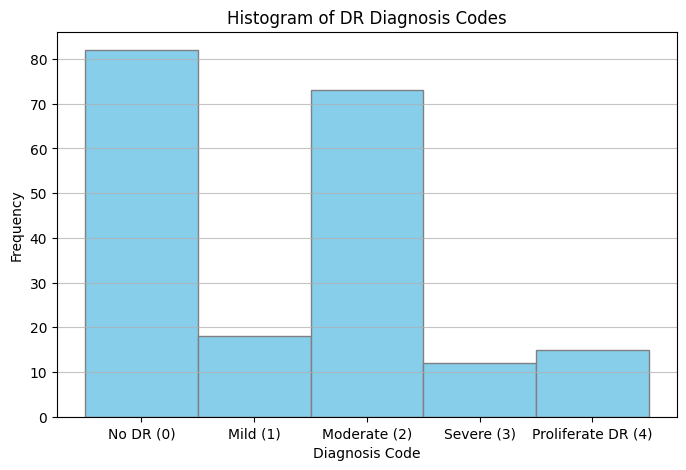

In [5]:
# YOUR CODE HERE

# A histogram of the diagnosis codes
plt.figure(figsize=(8, 5))
plt.hist(labels['diagnosis'], bins=np.arange(6) - 0.5, edgecolor='gray', color='skyblue')
plt.xlabel('Diagnosis Code')
plt.ylabel('Frequency')
plt.title('Histogram of DR Diagnosis Codes')
plt.xticks(np.arange(5), ['No DR (0)', 'Mild (1)', 'Moderate (2)', 'Severe (3)', 'Proliferate DR (4)'])
plt.grid(axis='y', alpha=0.75)
plt.show()

Comment on class balance: The classes are not balanced. Classes zero and two have many more entries that classes one, three and four.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Print 8 images from the data. What can you say about the size, focus/orientation of these images?

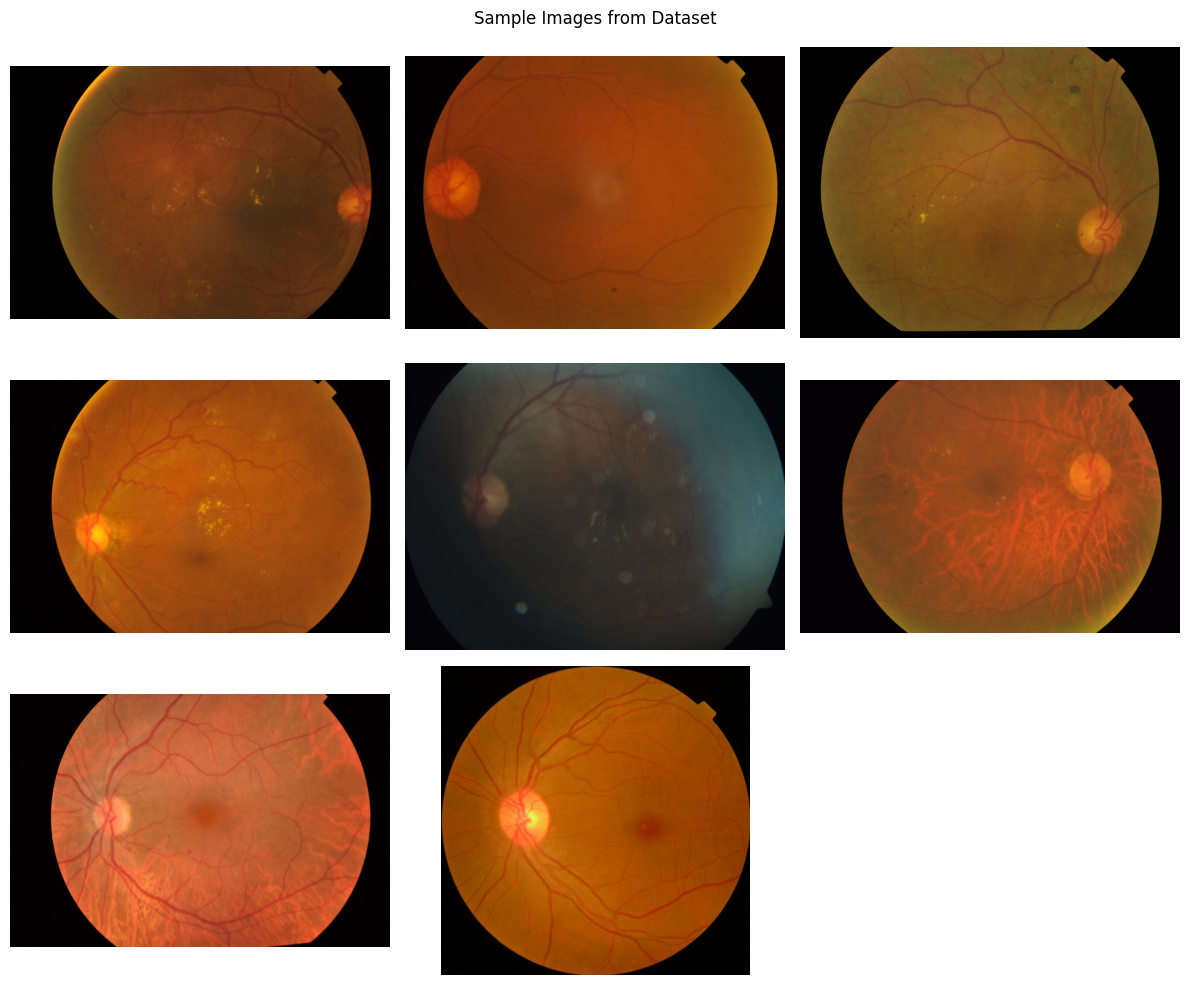

In [6]:
# FILL IN CODE HERE #

# Plotting the first 8 images from the dataset
plt.figure(figsize=(12, 10))
for i, img in enumerate(images[:8]):  # Select the first 8 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')  # Hide the axes

plt.suptitle('Sample Images from Dataset')
plt.tight_layout()
plt.show()

Comment on the size, focus/orientation of the 8 images: The size, focus, and orientation of these images is variable. Images are captured from different angles, and all have different fill amounts on the edges of the images. Generally, it seems the retenal nerve is either to the left or the right, as a general rule.

---
### Step 4: Data preprocessing

First, we will correct for class imbalance. Note that imbalanced data is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for this homework.

In [7]:
np.random.seed(1234)

no_refer = labels[labels.diagnosis.isin((0,1))]
refer = labels[labels.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the ``preprocess_data_part1()`` function defined below to generate lists of images and labels (images_mini and y_mini) based on the values in the temp_no_refer and temp_refer lists. Note that the size of the image is set to (224, 224).

In [8]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists

    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    temp_no_refer (str): list of labels for the no refer category
    temp_refer (str): list of labels for the refer category

    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini`
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue


        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )

        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten()

    return images_mini, y_mini

In [9]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(
    IMAGE_PATH, LABEL_PATH, temp_no_refer, temp_refer
)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


#### <span style="color:chocolate"> Exercise 4 (20 points) </span>

Create train, validation, and test data. Implement the `preprocess_data_part2()` function according to the following guidelines:

1. shuffle images and labels before splitting the data

2. use a (0.6,0.2,0.2)train/validation/test set split

3. perform image transformation and augmentation, as follows:
    * Applied on training set only:
         - create additional copies (augmentations) of the training images by flipping left right each image (Hint: use the method available in the tf.image module).
         - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 192 images and labels.
    * Applied on training, validation, and test sets:
        - rescale images by dividing each pixel by 255.0

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [10]:
def preprocess_data_part2(images, labels, splits):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    labels (np.ndarray): Labels of shape (N,)
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # Shuffle the data
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    # Calculate split sizes
    n_total = len(images)
    train_size = int(splits[0] * n_total)
    val_size = int(splits[1] * n_total)

    # Split the data
    X_train, X_val, X_test = images[:train_size], images[train_size:train_size + val_size], images[train_size + val_size:]
    y_train, y_val, y_test = labels[:train_size], labels[train_size:train_size + val_size], labels[train_size + val_size:]

    # Image augmentation: random flip left-right (only on training data)
    X_train_augm = tf.image.flip_left_right(X_train)

    # Concatenate original X_train and augmented X_train_augm data
    X_train = tf.concat([X_train, X_train_augm], axis=0)

    # Concatenate y_train (note the label is preserved)
    y_train = tf.concat([y_train, y_train], axis=0)

    # Shuffle X_train and y_train, i.e., shuffle two arrays in the same order
    shuffle_indices = tf.random.shuffle(tf.range(tf.shape(X_train)[0]))
    X_train = tf.gather(X_train, shuffle_indices)
    y_train = tf.gather(y_train, shuffle_indices)

    # Convert TensorFlow tensors to numpy arrays if necessary
    X_train = X_train.numpy() if isinstance(X_train, tf.Tensor) else X_train
    y_train = y_train.numpy() if isinstance(y_train, tf.Tensor) else y_train
    X_val = X_val.numpy() if isinstance(X_val, tf.Tensor) else X_val
    y_val = y_val.numpy() if isinstance(y_val, tf.Tensor) else y_val
    X_test = X_test.numpy() if isinstance(X_test, tf.Tensor) else X_test
    y_test = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test

    # Rescale training, validation, and test images by dividing each pixel by 255.0
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0

    return X_train, y_train, X_val, y_val, X_test, y_test


In [11]:
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 5 (20 points) </span>

The objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. You are interested in exploring binary classification of 'no refer' and 'refer'.

Implement a CNN classifier according to the following guidelines (let's call this model1; this model will serve as our baseline classifier):

1. Implement this model using the TF Keras API.
1. The model receives input images of size 224 x 224 x 3 (that is, the images have three color channels)
2. The input data goes through one convolutional layer that has the following specifications:
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
3. The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). Note: this will reduce the size of the feature maps.
4. The max-pooling layer is followed by a dropout layer with rate = 0.3.
5. The dropout layer is followed by a flattening layer.
6. The last layer of the model is the classification head.
7. Build and compile the model using the Adam optimizer and learning_rate = 0.1. Print summary of the model.
8. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation below to the fit() method as "callbacks=[early_stopping]").
9. How many parameters does the model have?
10. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation datasets.

In [12]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
verbose=1,
patience=4,
mode='max',
restore_best_weights=True)

In [13]:
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the model
model1 = tf.keras.Sequential([
    # Add convolutional layer
    tf.keras.layers.Conv2D(
        filters=12,
        kernel_size=(4, 4),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        activation='relu',
        input_shape=(224, 224, 3),
        name='conv_1'
    ),
    # Add max pooling layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Add dropout layer
    tf.keras.layers.Dropout(rate=0.3),
    # Add flattening layer
    tf.keras.layers.Flatten(),
    # Add classification layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Build and compile the model
model1.build(input_shape=(None, 224, 224, 3))
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Print model summary
model1.summary()

# Train the model on (X_train, y_train) data
history = model1.fit(
    X_train,
    y_train,
    epochs=20,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val)
)

# Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val)
train_acc = model1.evaluate(X_train, y_train)[1]
val_acc = model1.evaluate(X_val, y_val)[1]

print(f"Training accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 12)      588       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 12)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 12)      0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 1)                 150529    
                                                                 
Total params: 151117 (590.30 KB)
Trainable params: 151117 (590.30 KB)
Non-trainable params: 0 (0.00 Byte)
________________

How many parameters does model1 have? `model1` has a total of 151117 parameters, of which all 151117 are trainable. Consequently, 0 of the parameters are non-trainable.

Comment on model1 accuracy on training vs. validation data: `model1` has a training accuracy of 0.552 and a validation accuracy of 0.406. These are both middling, and there is more room for complexity and improvement.


#### <span style="color:chocolate"> Exercise 6 (20 points) </span>

Next, you will build a model with a more complex CNN architecture than the baseline CNN classifier above. Your tasks are as follows:

1. Implement this more complex CNN model (call this model2). Note that you are free to experiment with the number of hidden convolutional layers and hyperparameter values. The only requirement is that the minimum number of parameters be greater than 1M.
2. Explain how your implementation differs from the baseline CNN classifier.
3. Train the model on (X_train, y_train) data for 20 epochs. Add early stopping (Hint: pass the early_stopping implementation above to the fit() method as "callbacks=[early_stopping]").
4. How many parameters does the model have?
5. Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val) data. Comment on model performance on training vs. validation performance relative to the baseline model.

In [14]:
### YOUR CODE HERE ###
# Initialize model2
model2 = tf.keras.Sequential([
    # First convolutional block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.4),

    # Flattening and output
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Build and compile the model
model2.build(input_shape=(None, 224, 224, 3))
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Print model summary
model2.summary()

# Train the model on (X_train, y_train) data
history = model2.fit(
    X_train,
    y_train,
    epochs=20,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val)
)

# Evaluate the accuracy of the model on (X_train, y_train) and (X_val, y_val)
train_acc = model2.evaluate(X_train, y_train)[1]
val_acc = model2.evaluate(X_val, y_val)[1]

print(f"Training accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                      

How many parameters does model2 have? `model2` has 13132321 total params, of which 100% are trainable.


Comment on model2 performance on training vs. validation performance relative to the baseline model: The training accuracy (0.833) and the validation accuracy (0.844) of `model2` are much improved relative to `model1` which had lower training accuracy of 0.552 and a validation accuracy of 0.406. Therefore, we would prefer `model2` because its complexity significantly improves accuracy.


---
### Step 6: Evaluation

#### <span style="color:chocolate"> Exercise 7 (10 points) </span>

You will now use the test data to evaluate the performance (accuracy) of model1 and model2 on unseen data. Which model performs best? Is this result expected?

In [15]:
### YOUR CODE HERE ###
test_acc_model1 = model1.evaluate(X_test, y_test)[1]
print(f"Test accuracy of model1: {test_acc_model1}")

# Evaluate the accuracy of model2 on the test data
test_acc_model2 = model2.evaluate(X_test, y_test)[1]
print(f"Test accuracy of model2: {test_acc_model2}")

# Compare performance
if test_acc_model1 > test_acc_model2:
    print("Model1 performs better on the test data.")
elif test_acc_model1 < test_acc_model2:
    print("Model2 performs better on the test data.")
else:
    print("Both models perform equally on the test data.")


1/1 [==============================] - 0s 134ms/step - loss: 0.6953 - accuracy: 0.4375
Test accuracy of model1: 0.4375
1/1 [==============================] - 0s 116ms/step - loss: 0.4353 - accuracy: 0.7500
Test accuracy of model2: 0.75
Model2 performs better on the test data.


Which model performs best? `model2`

Is this result expected? Typically, a more complex model (like `model2` with more parameters) might be expected to perform better due to its increased learning capacity, given that the more complex model is not overfit. In this case, the more complex model is superior.